In [1]:
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

2025-05-18 07:09:58.536098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 07:09:58.854568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747552198.960976     637 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747552198.991659     637 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747552199.230431     637 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
split_path = "split_data"

with h5py.File(os.path.join(split_path, "train_data.h5"), 'r') as f:
    X_train = f['X'][:]
    Y_train = f['Y'][:]
    
with h5py.File(os.path.join(split_path,"val_data.h5"), 'r') as f:
    X_val = f['X'][:]
    Y_val = f['Y'][:]
    
with h5py.File(os.path.join(split_path,"test_data.h5"), 'r') as f:
    X_test = f['X'][:]
    Y_test = f['Y'][:]

In [3]:

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # cast to float32 here
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [4]:

def build_unet(input_size=(128, 128, 4)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)

    # Decoder
    up1 = layers.UpSampling2D((2, 2))(conv4)
    up1 = layers.concatenate([up1, conv3], axis=-1)
    conv5 = layers.Conv2D(256, (3, 3), padding='same')(up1)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(256, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)

    up2 = layers.UpSampling2D((2, 2))(conv5)
    up2 = layers.concatenate([up2, conv2], axis=-1)
    conv6 = layers.Conv2D(128, (3, 3), padding='same')(up2)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(128, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)

    up3 = layers.UpSampling2D((2, 2))(conv6)
    up3 = layers.concatenate([up3, conv1], axis=-1)
    conv7 = layers.Conv2D(64, (3, 3), padding='same')(up3)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(64, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    # Output layer: 1 channel with sigmoid activation for binary mask
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_unet(input_size=(128, 128, 4))
model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred),
    metrics=['accuracy', dice_coefficient]
)

model.summary()


W0000 00:00:1747552234.978534     637 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,794,753 (29.73 MB)

 Trainable params: 7,789,121 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [5]:
# Callbacks for saving best model and early stopping
checkpoint = ModelCheckpoint('Models/brain_tumor_model1.keras', monitor='val_dice_coefficient', mode='max', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_dice_coefficient', mode='max', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coefficient', mode='max', factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=2,
    callbacks=[checkpoint, earlystop, reduce_lr]
)


Epoch 1/2


2025-05-18 07:11:59.707253: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9804 - dice_coefficient: 0.7852 - loss: 0.1787
Epoch 1: val_dice_coefficient improved from -inf to 0.52441, saving model to Models/brain_tumor_model1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


679/679 ━━━━━━━━━━━━━━━━━━━━ 1744s 3s/step - accuracy: 0.9804 - dice_coefficient: 0.7854 - loss: 0.1784 - val_accuracy: 0.9860 - val_dice_coefficient: 0.5244 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 2/2
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9898 - dice_coefficient: 1.1463 - loss: -0.2685
Epoch 2: val_dice_coefficient did not improve from 0.52441
679/679 ━━━━━━━━━━━━━━━━━━━━ 1708s 3s/step - accuracy: 0.9898 - dice_coefficient: 1.1463 - loss: -0.2685 - val_accuracy: 0.9858 - val_dice_coefficient: 0.4771 - val_loss: 0.3362 - learning_rate: 0.0010


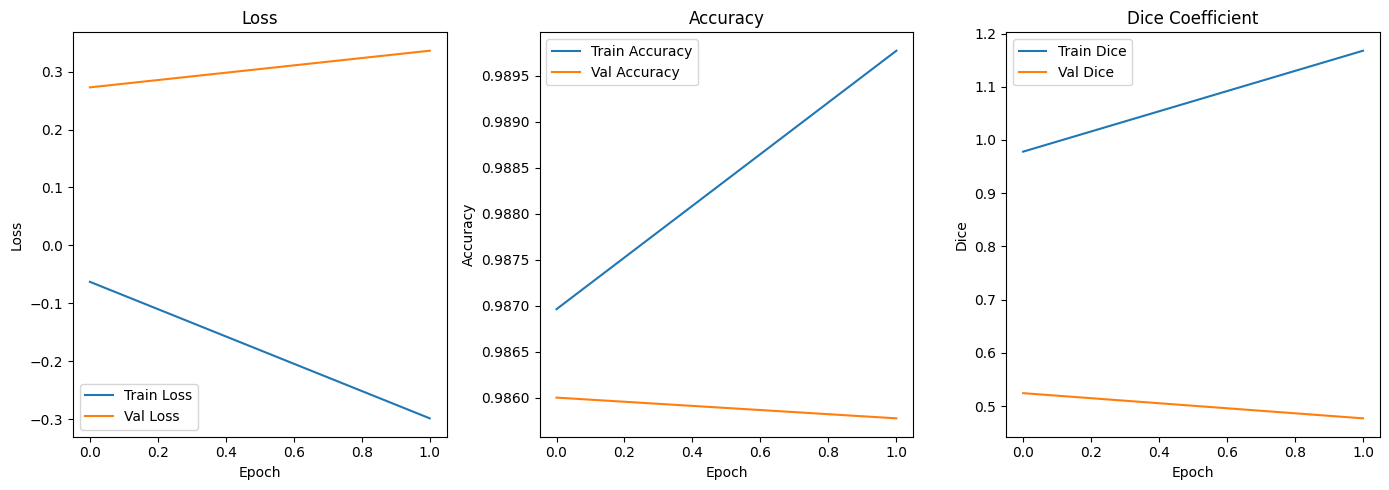

In [7]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.savefig("outputs/accuracies/brain_tumor_model1.png", dpi=300, bbox_inches='tight')
    plt.show()

# Call the function
plot_training_history(history)


In [ ]:
# model.save('Models/brain_tumor_model.keras')